Creating dataset


In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Read the dataset
dataset = pd.read_csv('avocado.csv')

# Handling missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
numerical_columns = dataset.select_dtypes(include=[np.number]).columns.tolist()
imputer.fit(dataset[numerical_columns])
dataset[numerical_columns] = imputer.transform(dataset[numerical_columns])

# One-hot encode 'type' and 'region' columns
dataset = pd.get_dummies(dataset, columns=['type', 'region'])

# Convert 'Date' column to datetime type
dataset['Date'] = pd.to_datetime(dataset['Date'])
boolean_columns = dataset.select_dtypes(include='bool').columns
dataset[boolean_columns] = dataset[boolean_columns].astype(int)

# Scale 'Date' column to be within the range 0 to 1
scaler = MinMaxScaler()
dataset['Date'] = scaler.fit_transform(dataset['Date'].values.reshape(-1, 1))

scaler = MinMaxScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

# Remove 'Unnamed' columns
dataset_encoded = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]

# Keep 'AveragePrice' as a feature
X = dataset_encoded
Y = dataset_encoded['AveragePrice']

# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Save preprocessed training data
X_train.to_csv('avo2train.csv', index=False)

# Save preprocessed testing data
X_test.to_csv('avo2test.csv', index=False)

print("Preprocessed data saved successfully!")


Preprocessed data saved successfully!


Cleaning data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed training data
X_train = pd.read_csv('avo2train.csv')

columns_to_remove_outliers = ['Total Volume','AveragePrice', '4046', '4225', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
# Identify and remove outliers using modified IQR method for each specified column
def remove_outliers_custom_bounds(data, column, lower_bound, upper_bound):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_value = Q1 - lower_bound * IQR
    upper_bound_value = Q3 + upper_bound * IQR
    outliers = (data[column] < lower_bound_value) | (data[column] > upper_bound_value)
    data_cleaned = data[~outliers]
    return data_cleaned

# Set custom bounds for outlier removal
lower_bound = 0
upper_bound = 1

# Remove outliers using modified IQR method for each specified column
X_train_cleaned = X_train.copy()  # Create a copy to avoid modifying the original data
for column in columns_to_remove_outliers:
    X_train_cleaned = remove_outliers_custom_bounds(X_train_cleaned, column, lower_bound, upper_bound)


# Save the preprocessed training data without outliers
X_train_cleaned.to_csv('avocado_cleaned.csv', index=False)
print("Preprocessed data with outliers removed saved successfully!")


Preprocessed data with outliers removed saved successfully!


Step 1: Load the Data and Basic Exploration

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the preprocessed data
df = pd.read_csv("avocado_cleaned.csv")

# Display basic information about the DataFrame
print(df.info())

# Display the first few rows of the DataFrame
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        529 non-null    float64
 1   AveragePrice                529 non-null    float64
 2   Total Volume                529 non-null    float64
 3   4046                        529 non-null    float64
 4   4225                        529 non-null    float64
 5   4770                        529 non-null    float64
 6   Total Bags                  529 non-null    float64
 7   Small Bags                  529 non-null    float64
 8   Large Bags                  529 non-null    float64
 9   XLarge Bags                 529 non-null    float64
 10  year                        529 non-null    float64
 11  type_conventional           529 non-null    int64  
 12  type_organic                529 non-null    int64  
 13  region_Albany               529 non

Step 2: Scatterplots for Each Independent Variable Against the Dependent Variable (Price)

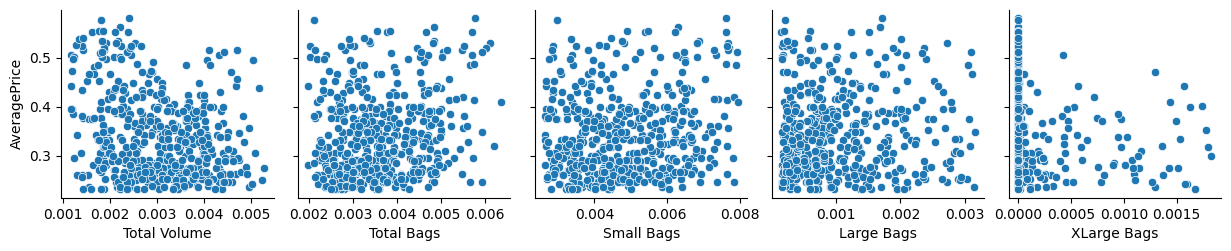

In [4]:
# Scatterplot for each independent variable against the dependent variable (AveragePrice)
sns.pairplot(df, x_vars=['Total Volume', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'], y_vars='AveragePrice', kind='scatter')
plt.show()


Step 3: Interpret the Strength of the Relationship via the Correlation Matrix

In [5]:
# Correlation matrix
correlation_matrix = df[['Total Volume', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'AveragePrice']].corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
              Total Volume  Total Bags  Small Bags  Large Bags  XLarge Bags  \
Total Volume      1.000000    0.407748    0.472175   -0.289313     0.130736   
Total Bags        0.407748    1.000000    0.971217    0.087375     0.009414   
Small Bags        0.472175    0.971217    1.000000   -0.152189    -0.009059   
Large Bags       -0.289313    0.087375   -0.152189    1.000000     0.032682   
XLarge Bags       0.130736    0.009414   -0.009059    0.032682     1.000000   
AveragePrice     -0.247282    0.191049    0.166542    0.100617    -0.093553   

              AveragePrice  
Total Volume     -0.247282  
Total Bags        0.191049  
Small Bags        0.166542  
Large Bags        0.100617  
XLarge Bags      -0.093553  
AveragePrice      1.000000  


Step 4: Fit a Linear Model to Predict Avocado Prices Using Linear Regression

In [6]:
# Fit linear regression model
X = df[['Total Volume', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']]
y = df['AveragePrice']
X = sm.add_constant(X)  # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print model summary
print(model.summary())
print(predictions)


                            OLS Regression Results                            
Dep. Variable:           AveragePrice   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     21.44
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           1.54e-19
Time:                        23:43:41   Log-Likelihood:                 614.95
No. Observations:                 529   AIC:                            -1218.
Df Residuals:                     523   BIC:                            -1192.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3350      0.016     21.382   

Step 5: Identify Variables to Use for Predicting Avocado Prices

Based on the scatterplots and correlation values, we can identify which variables have a relatively stronger correlation with the average price of avocados. These variables can be used for predicting avocado prices. From the scatterplots and correlation matrix, we can observe the relationships between independent variables and avocado prices. "Total bags and small bags" has a higher correlation coefficient and a clearer linear relationship with "AveragePrice," choose it as a predictor.

Step 6: Fit a Linear Model Using Selected Independent Variables

In [7]:
# Fit linear regression model with selected independent variables
X_selected = df[['Total Bags', 'XLarge Bags']]  # Example: Using Total Volume and Total Bags as predictors
X_selected = sm.add_constant(X_selected)  # adding a constant

model_selected = sm.OLS(y, X_selected).fit()
predictions_selected = model_selected.predict(X_selected)

# Print model summary for selected variables
print(model_selected.summary())

print(predictions_selected)



                            OLS Regression Results                            
Dep. Variable:           AveragePrice   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     12.56
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           4.68e-06
Time:                        23:43:41   Log-Likelihood:                 577.97
No. Observations:                 529   AIC:                            -1150.
Df Residuals:                     526   BIC:                            -1137.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2784      0.014     19.395      

A complete analysis

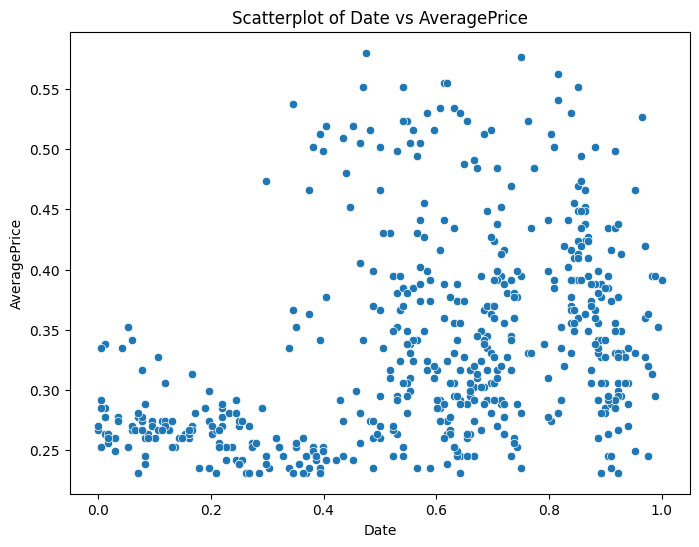

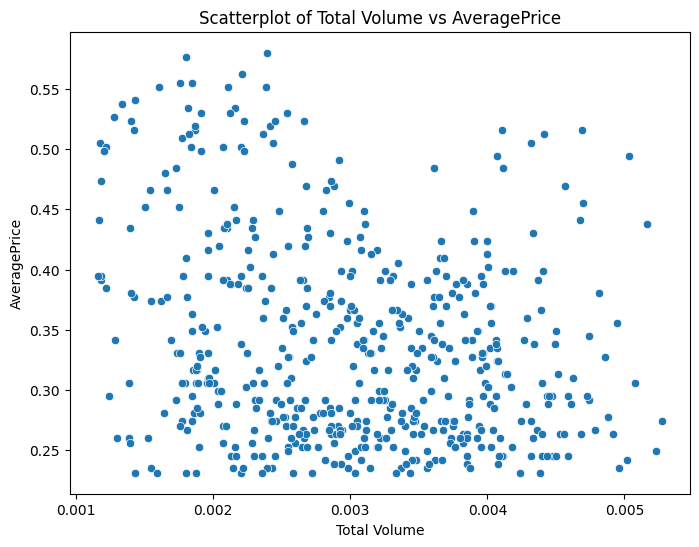

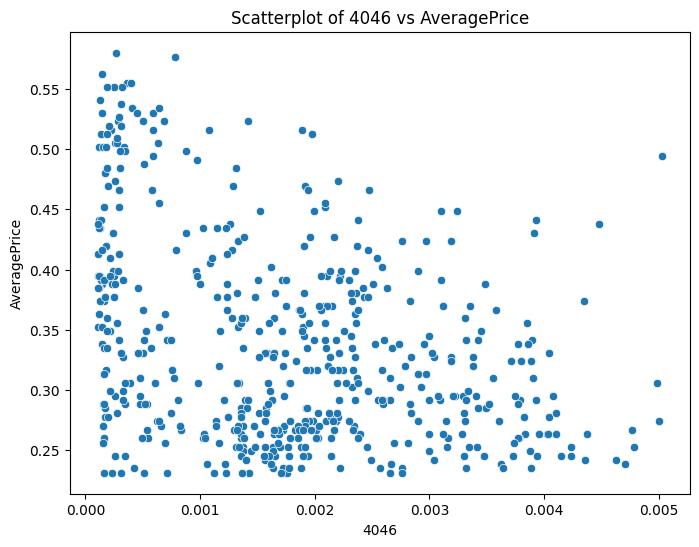

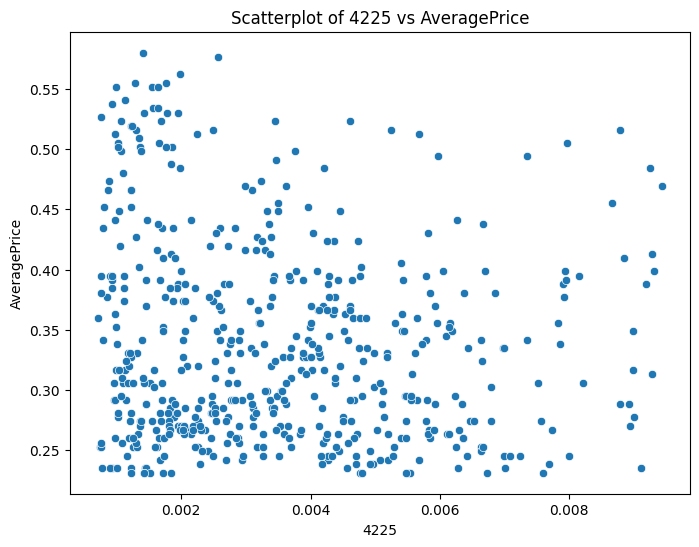

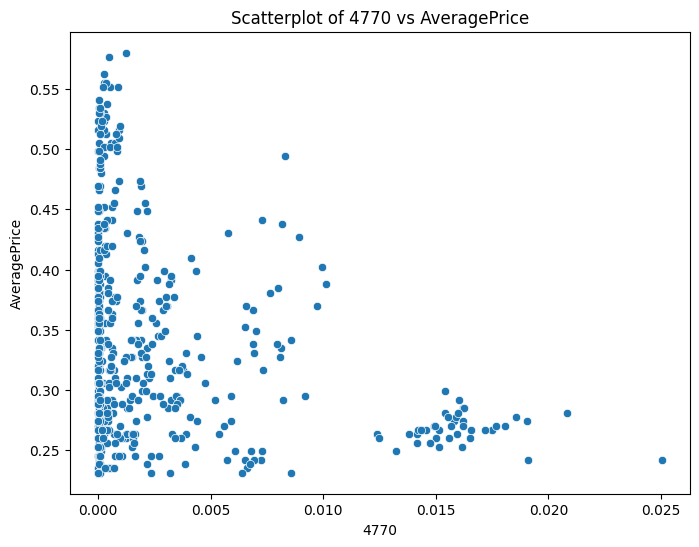

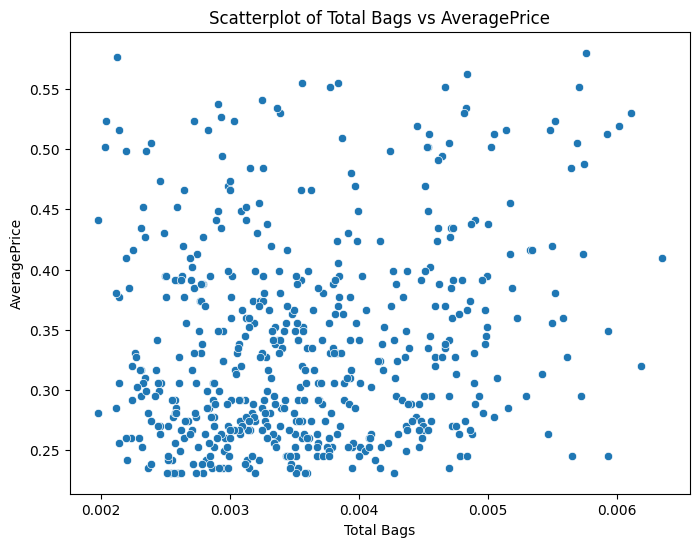

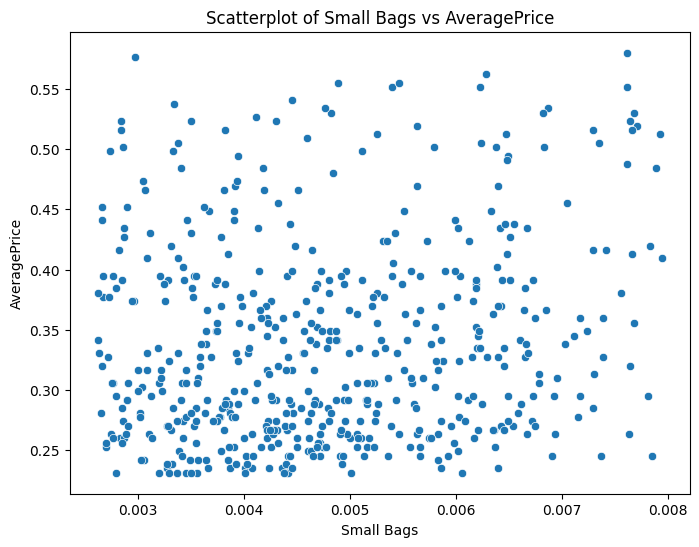

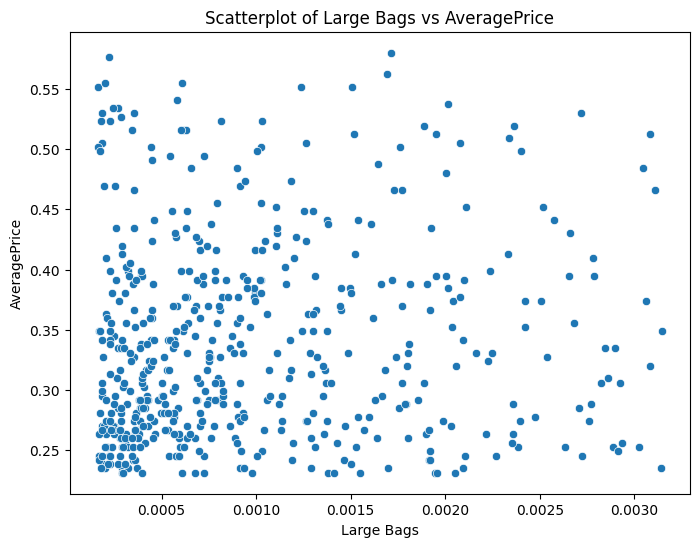

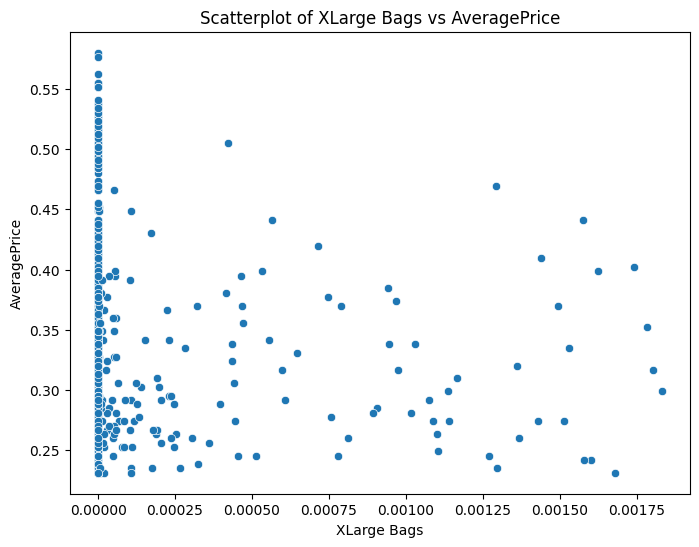

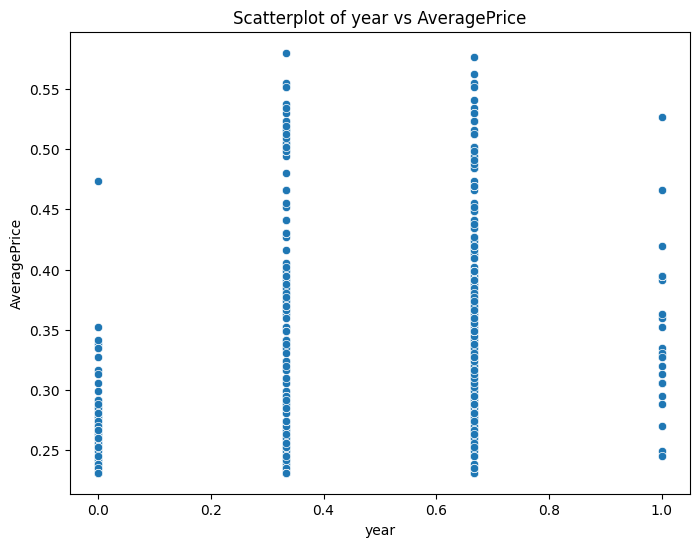

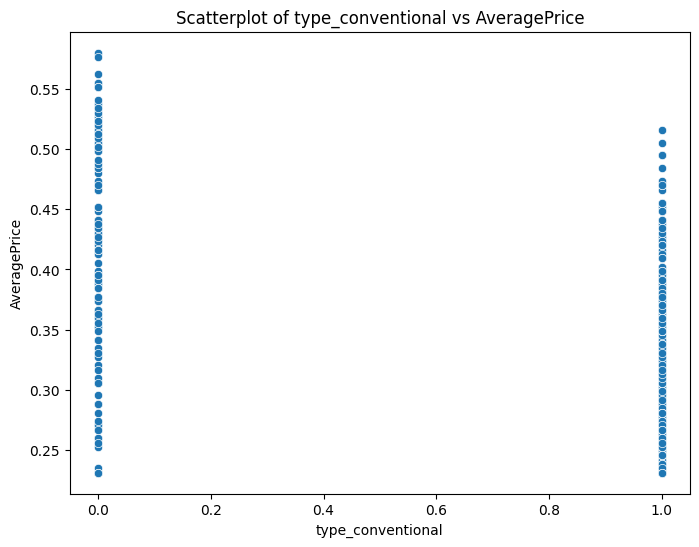

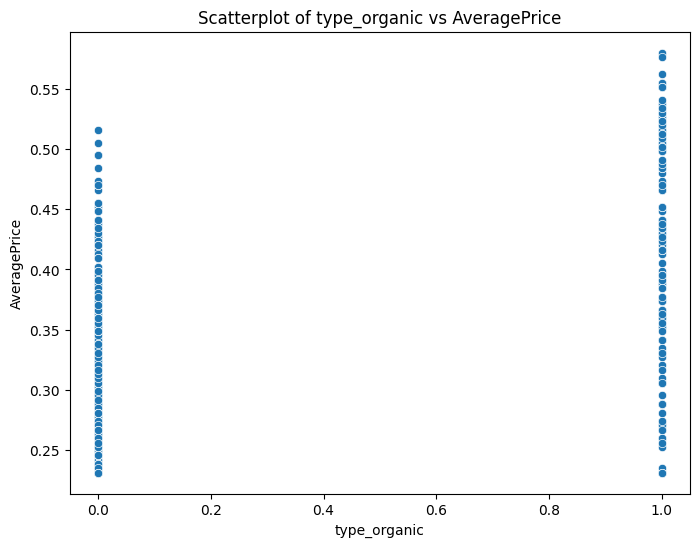

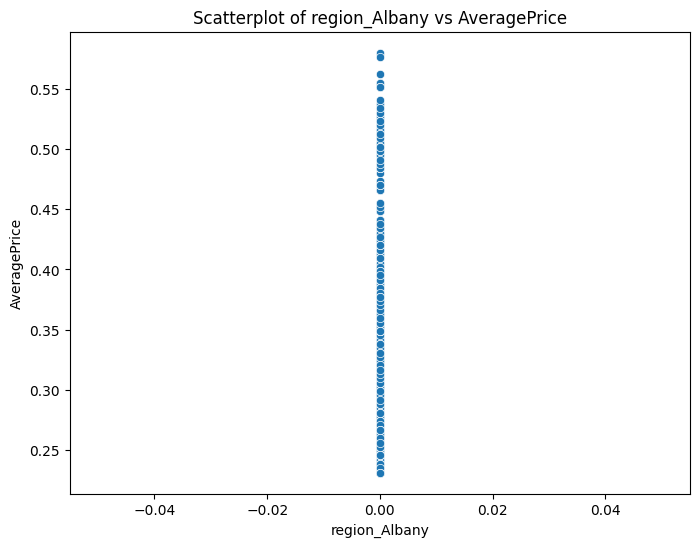

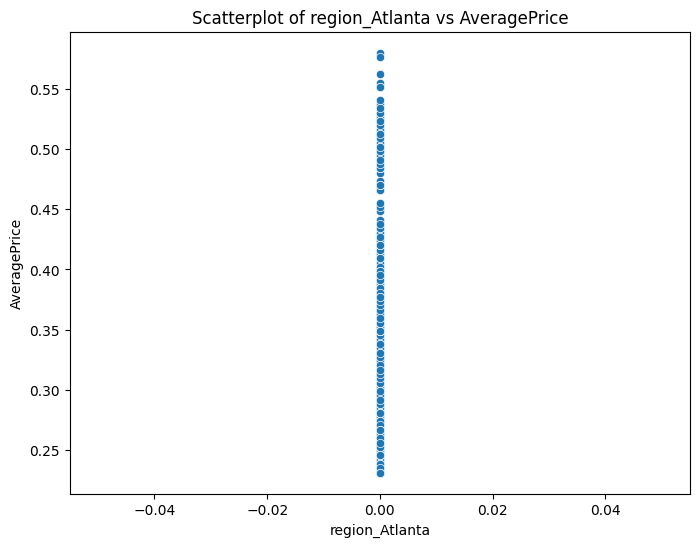

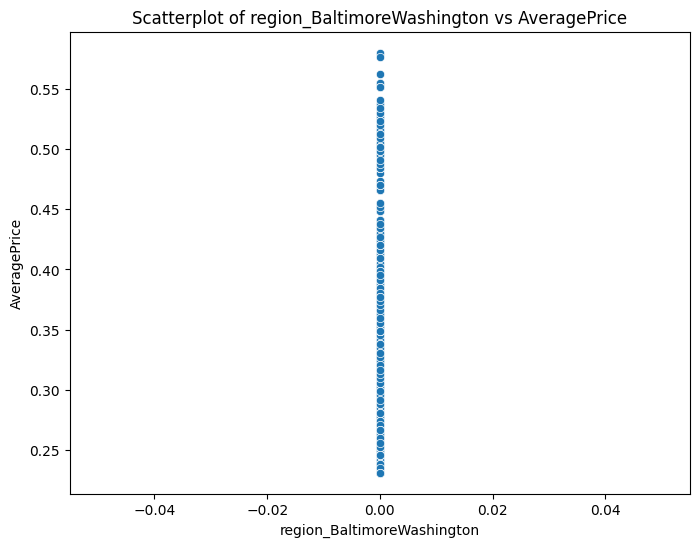

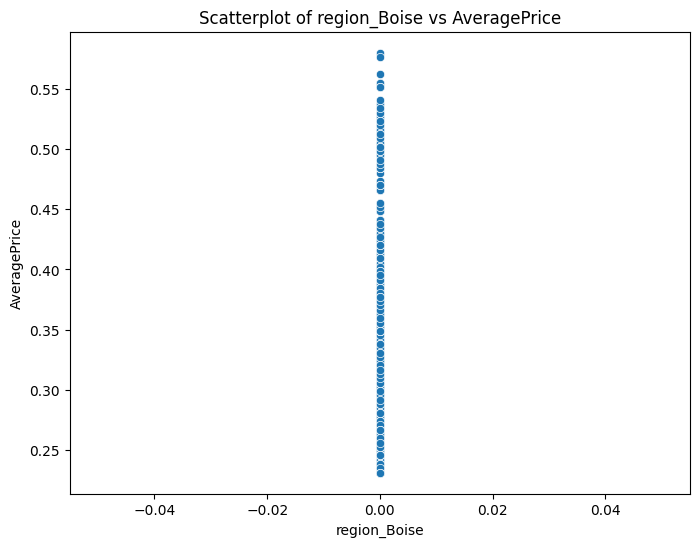

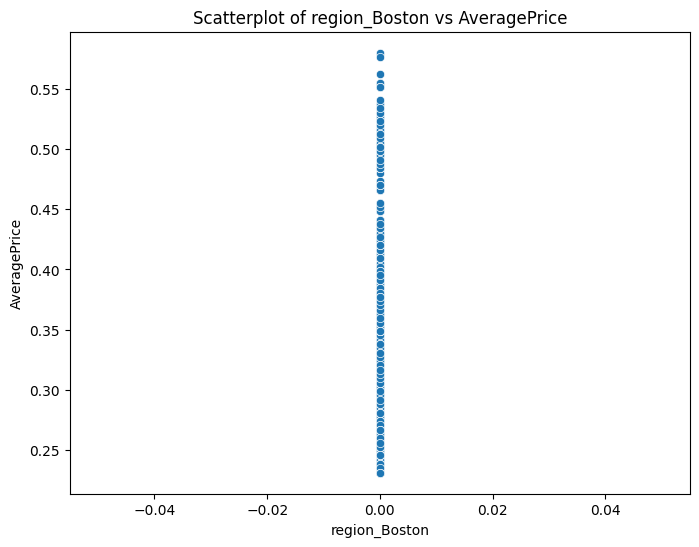

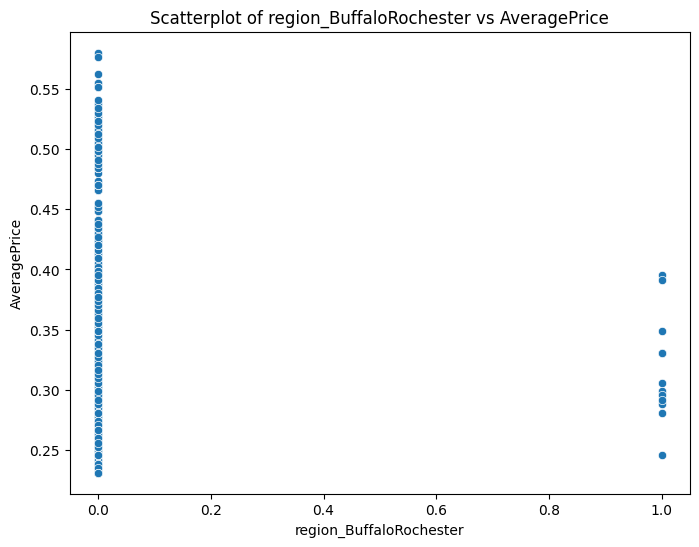

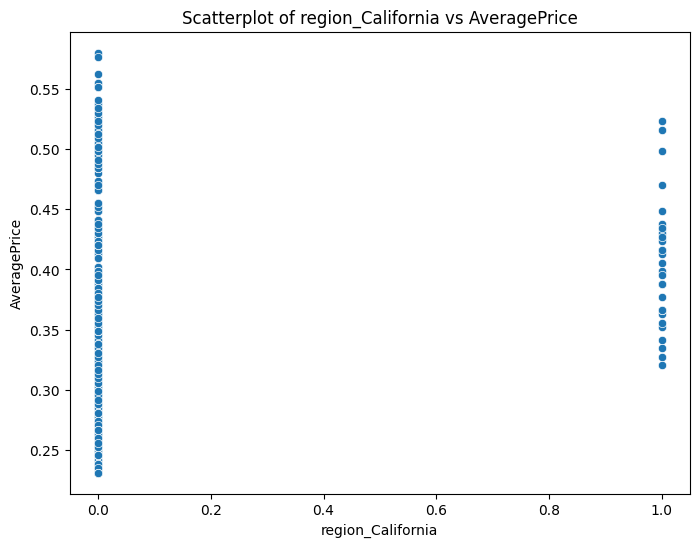

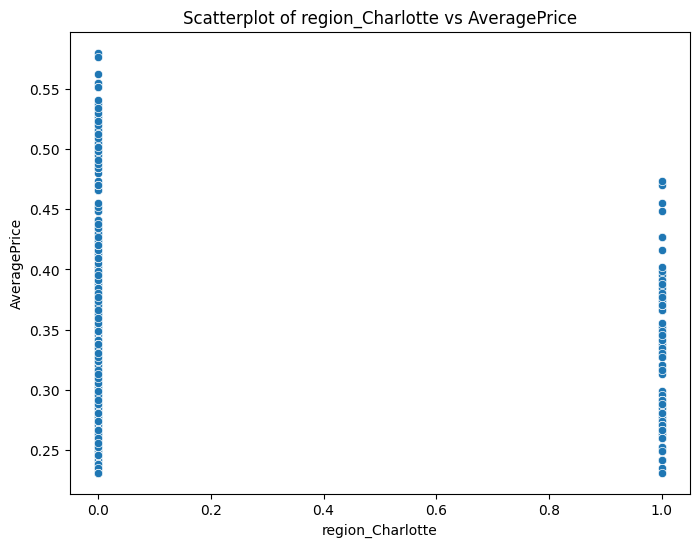

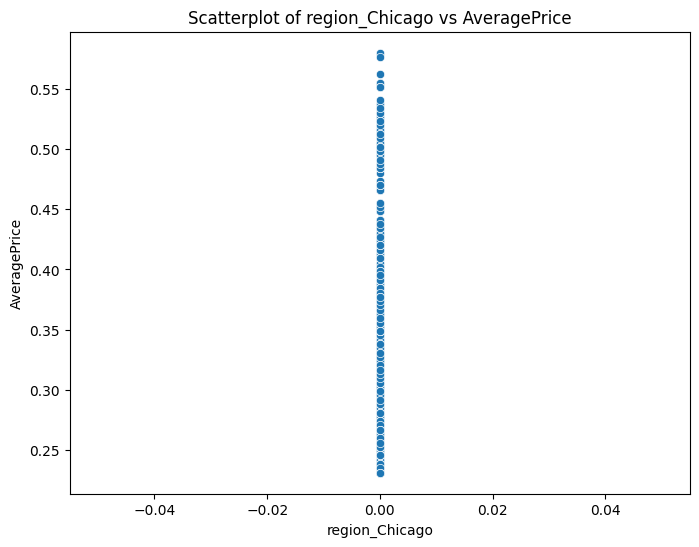

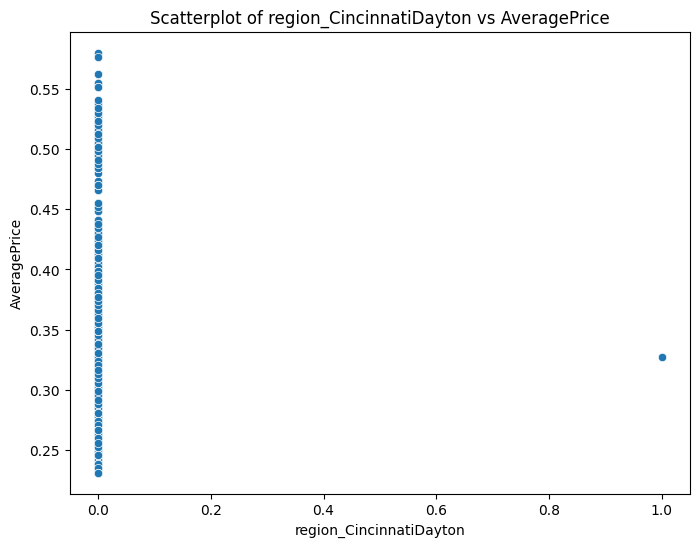

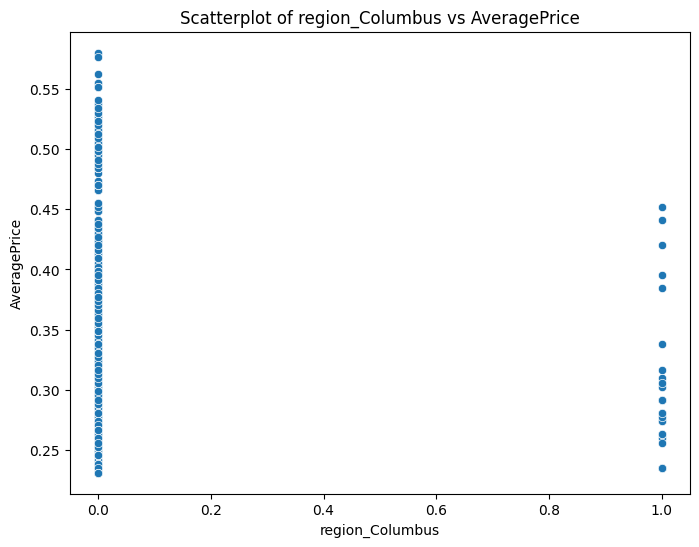

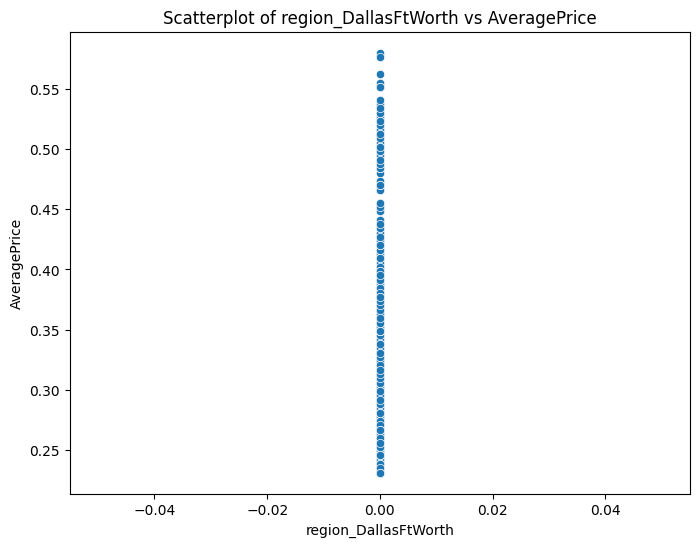

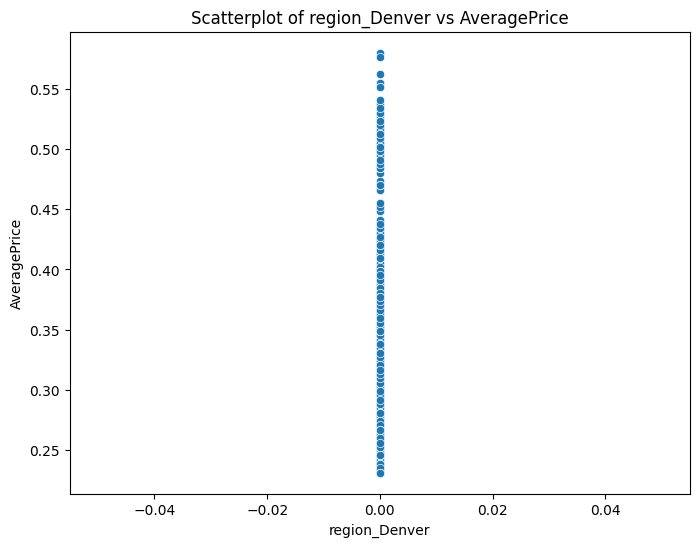

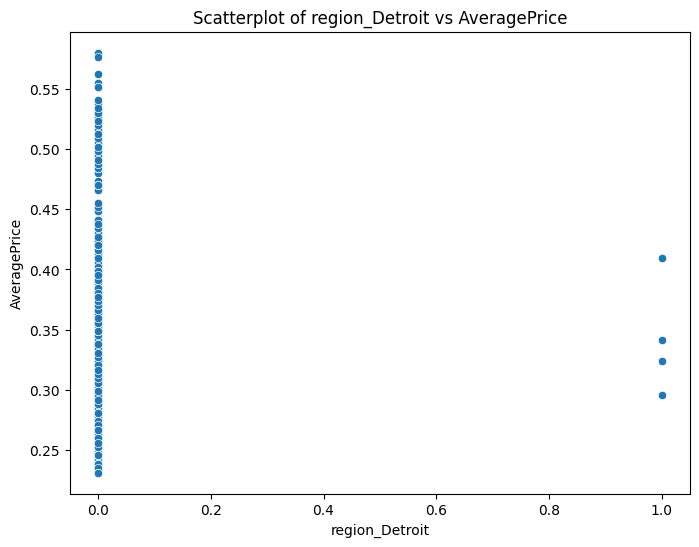

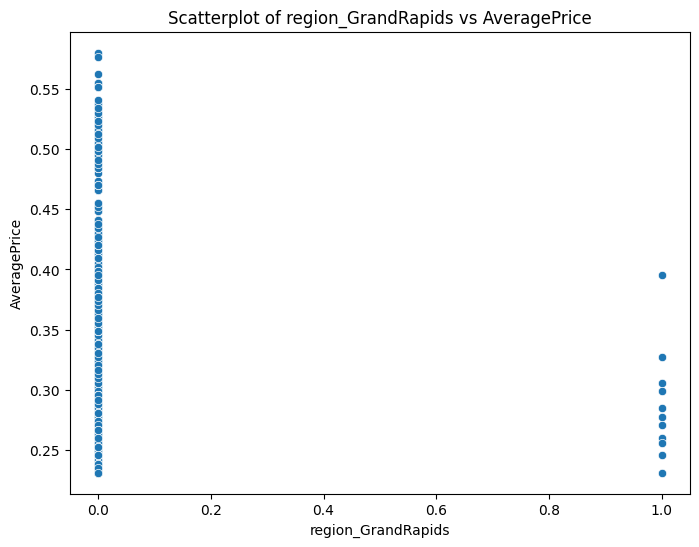

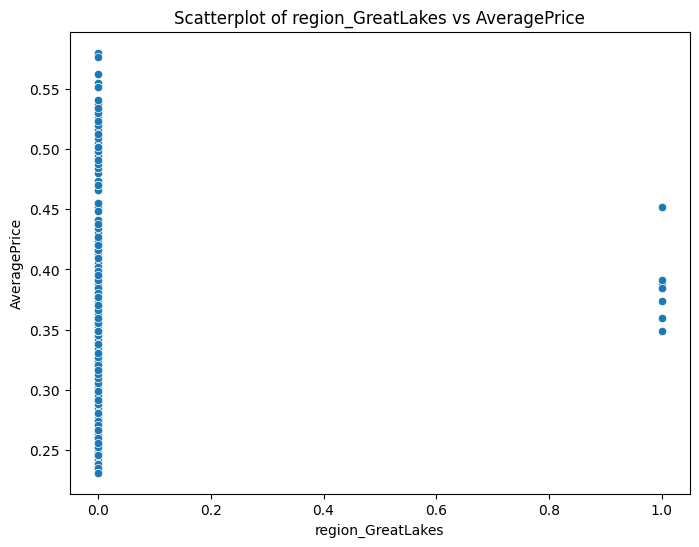

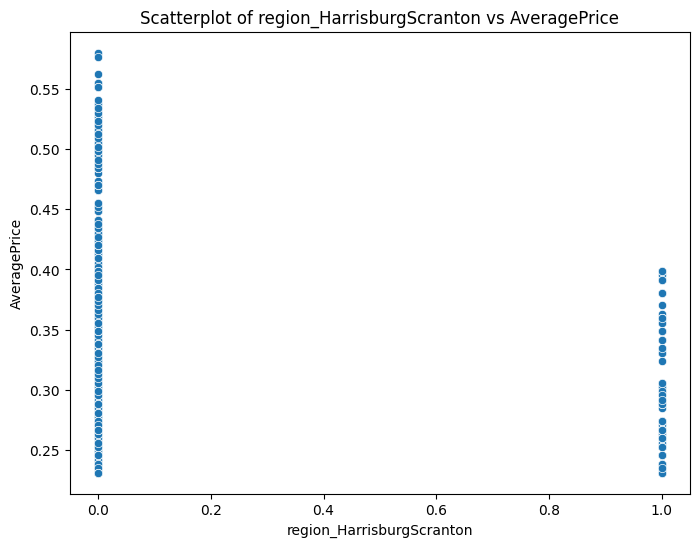

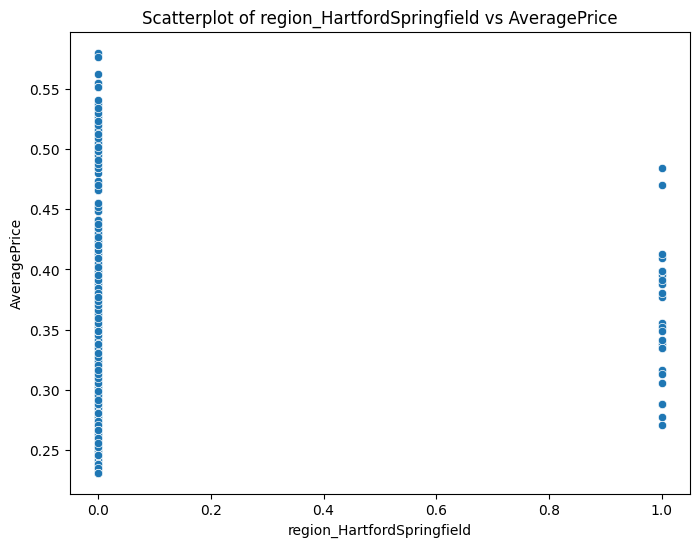

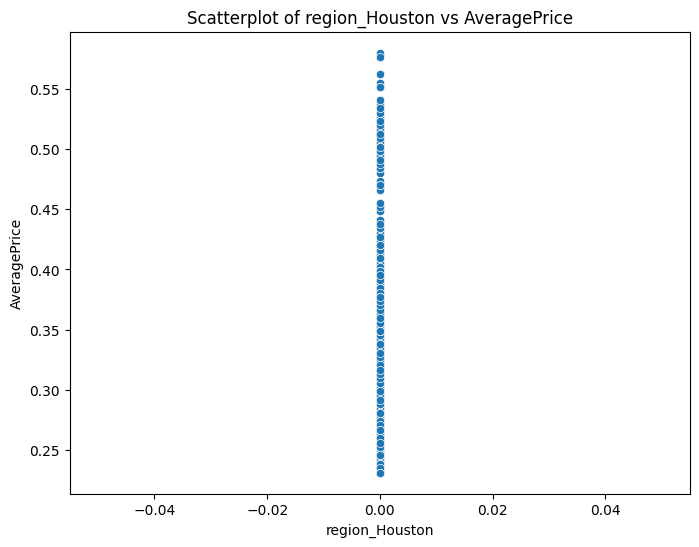

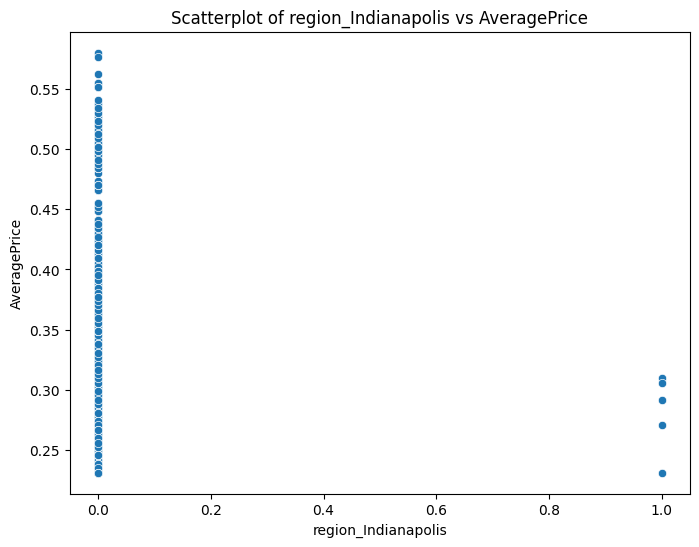

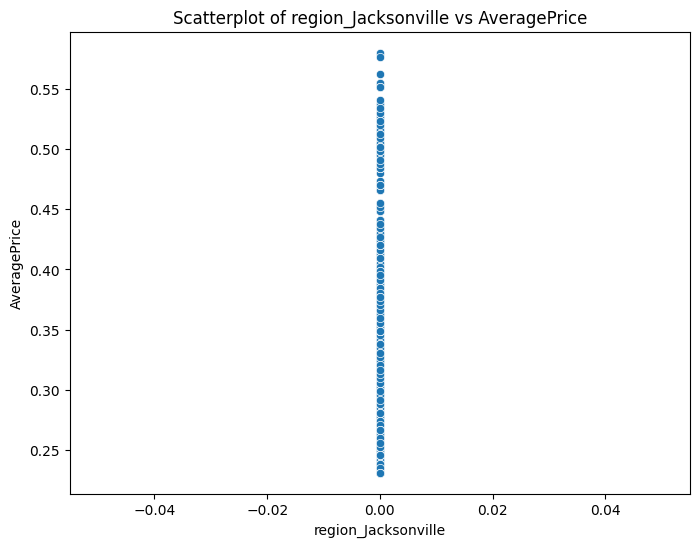

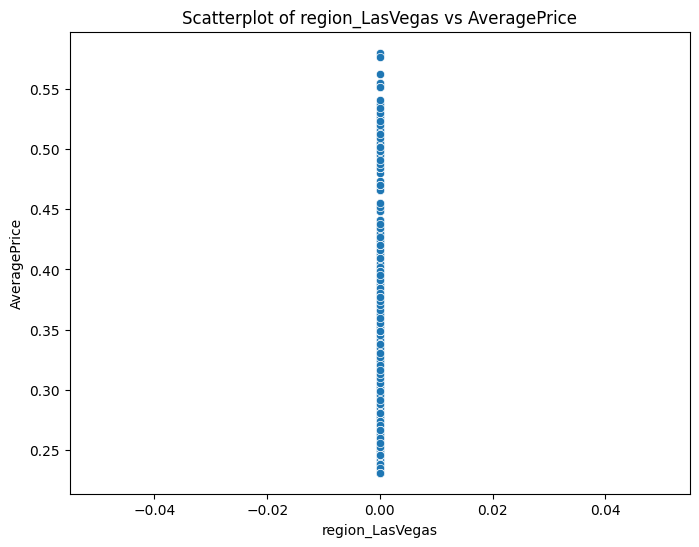

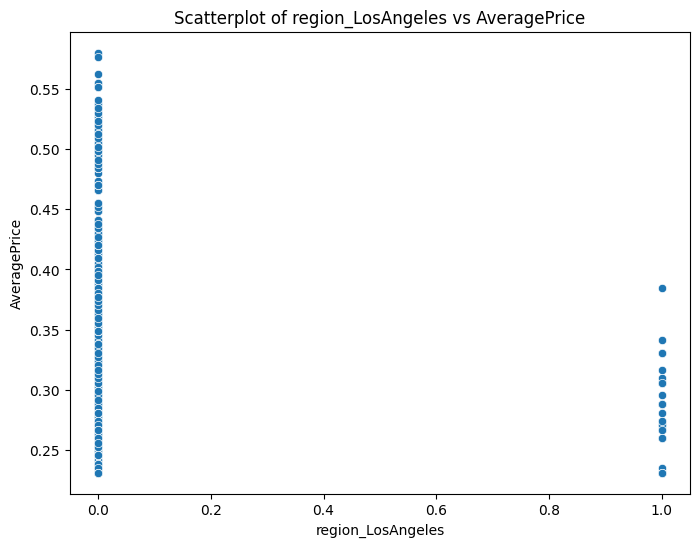

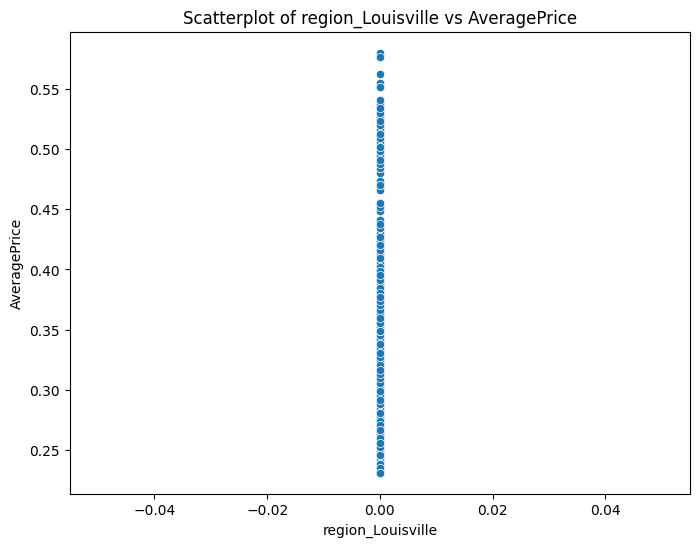

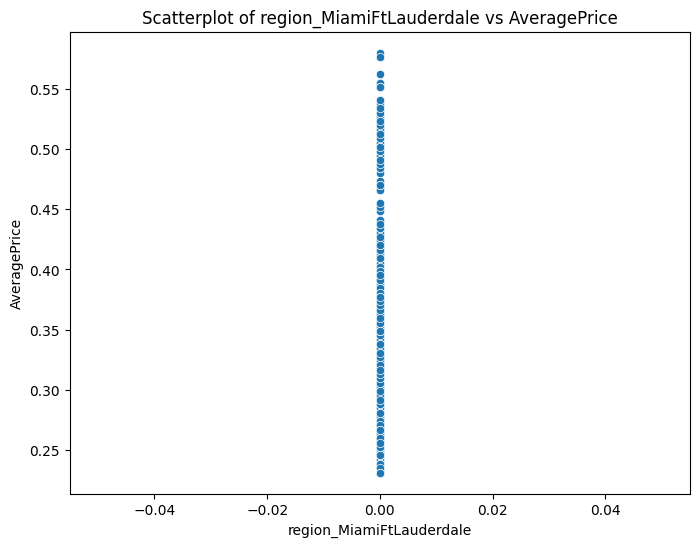

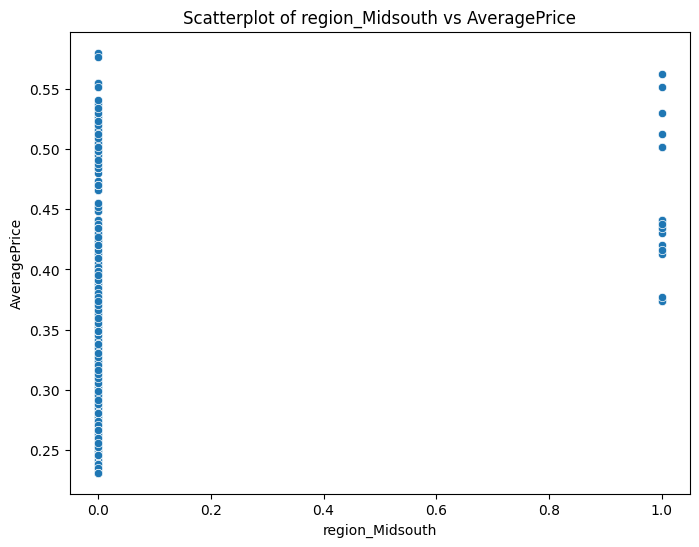

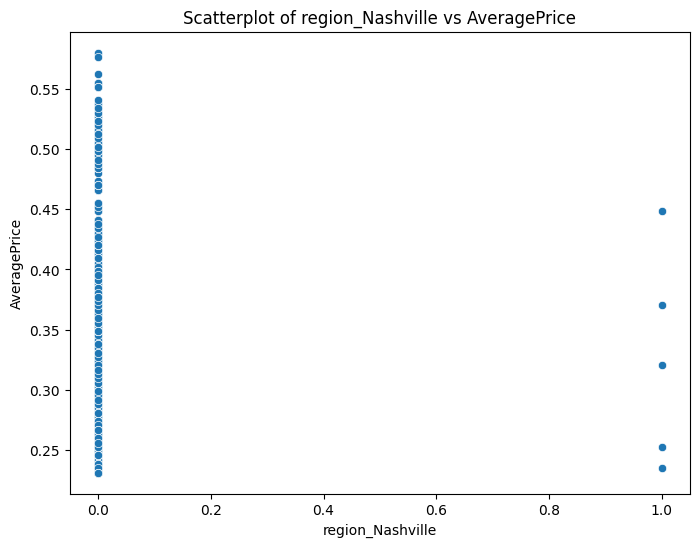

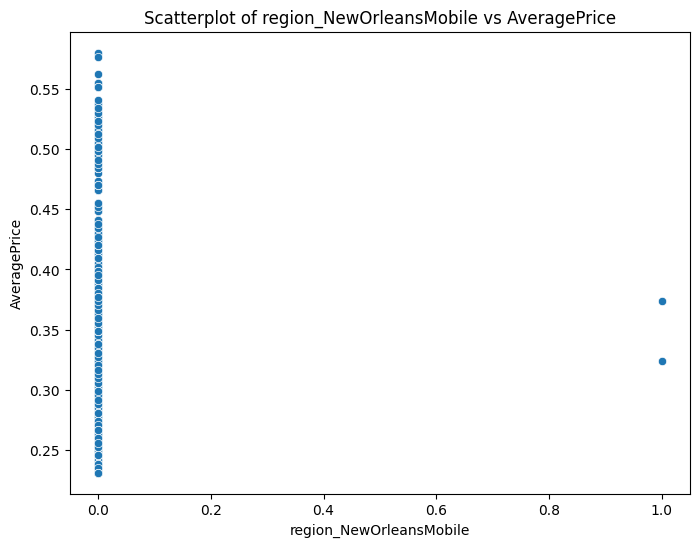

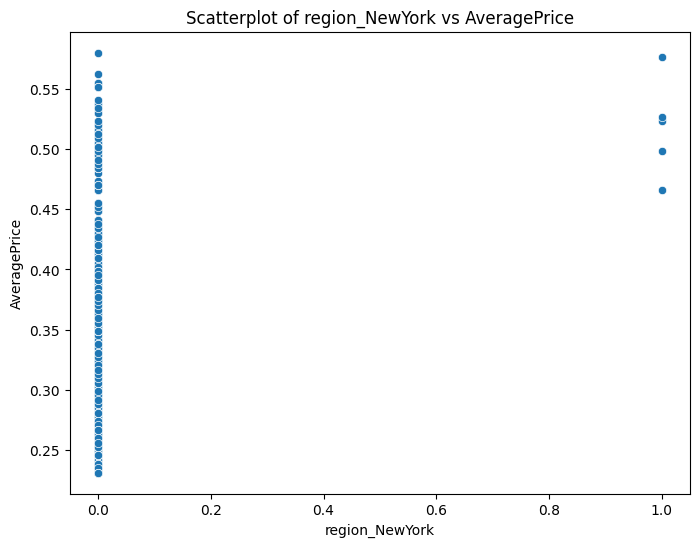

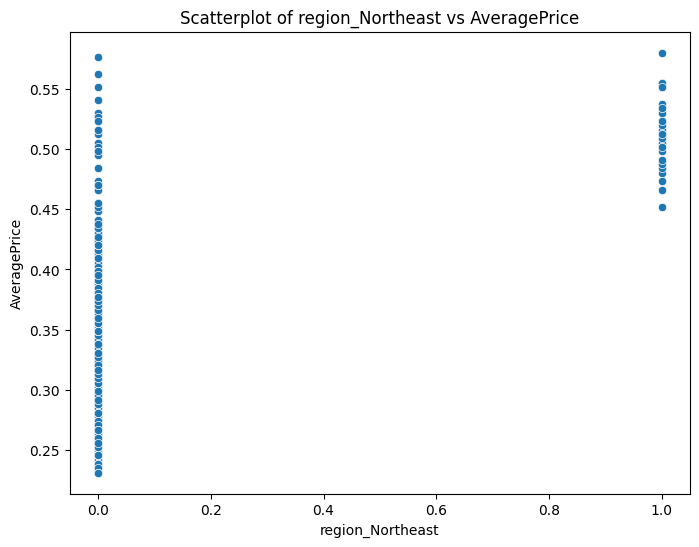

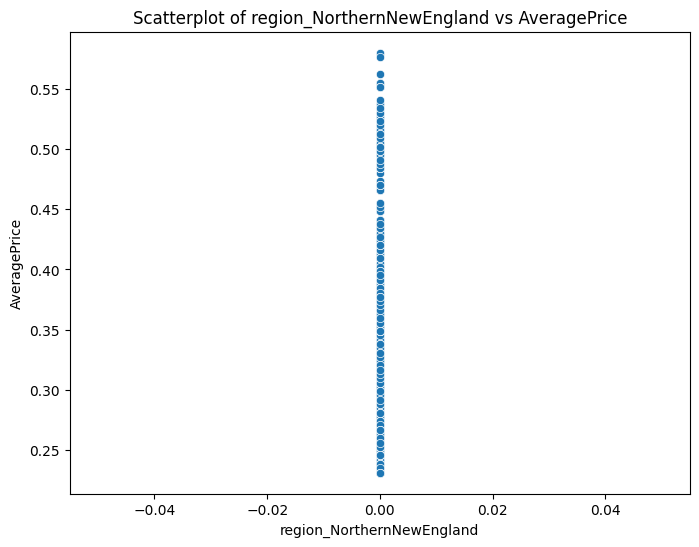

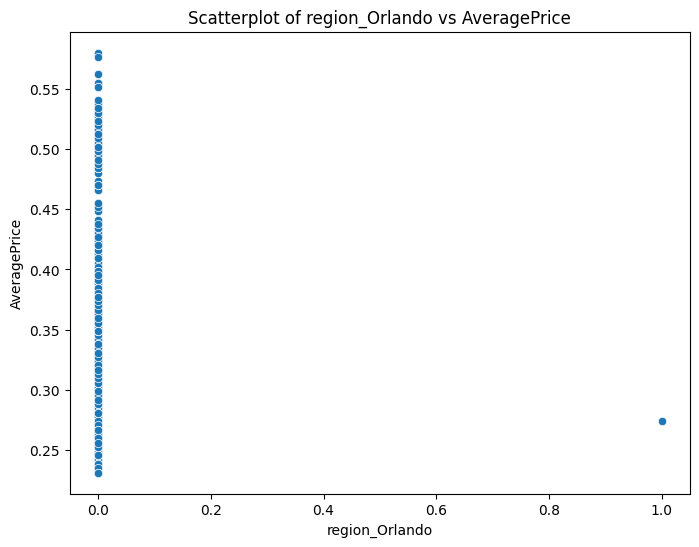

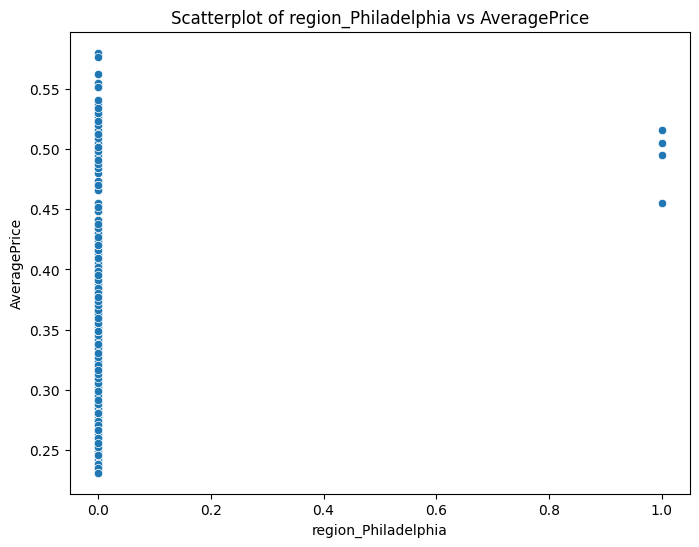

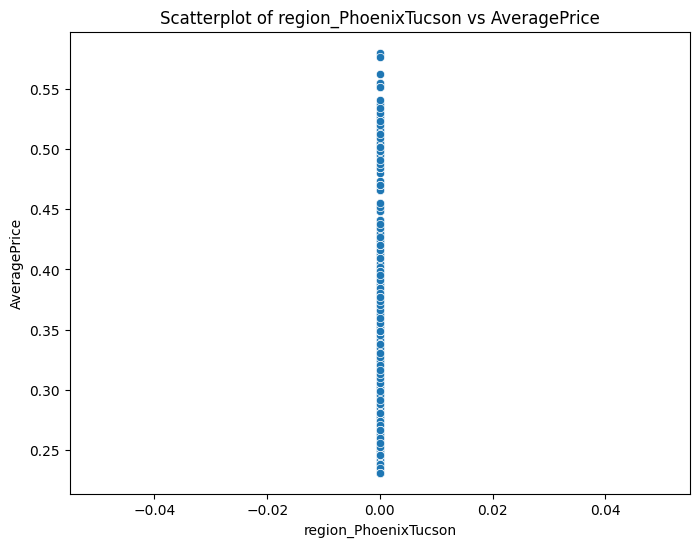

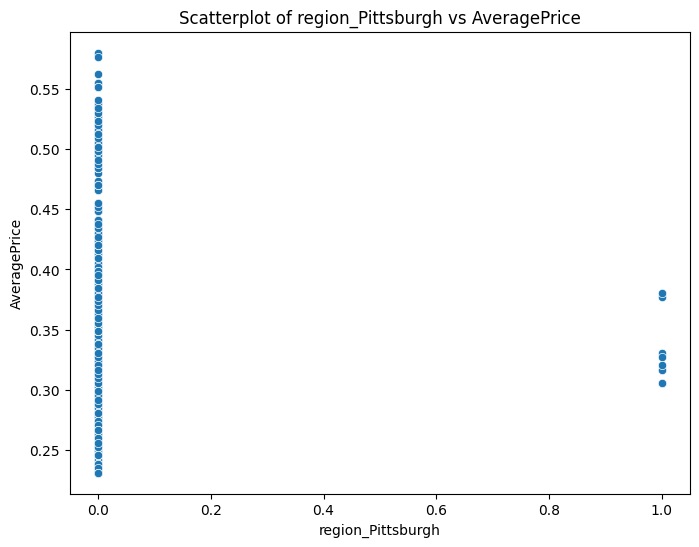

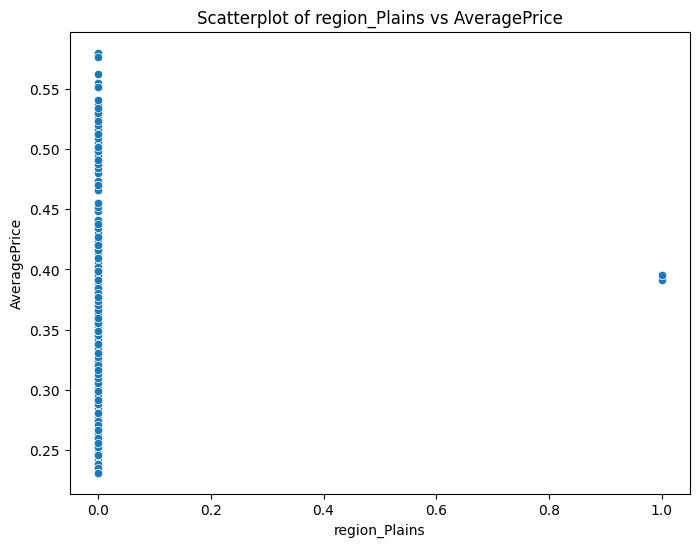

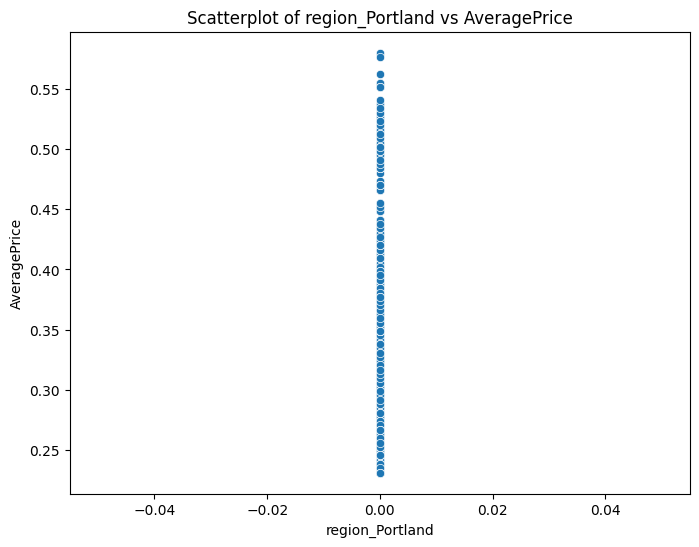

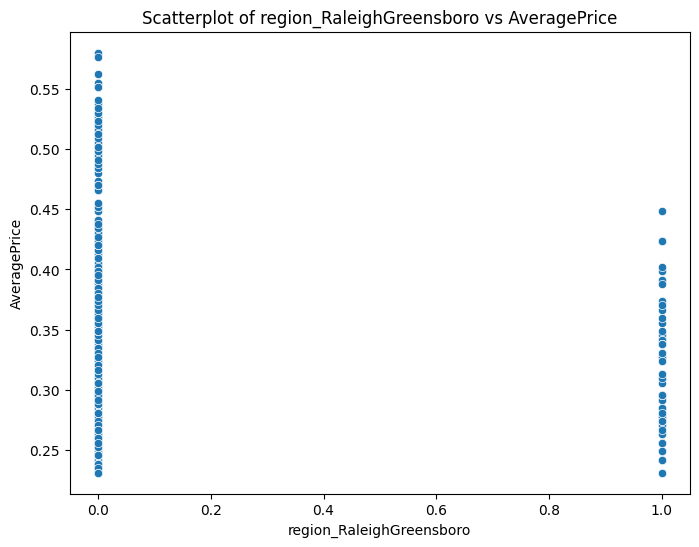

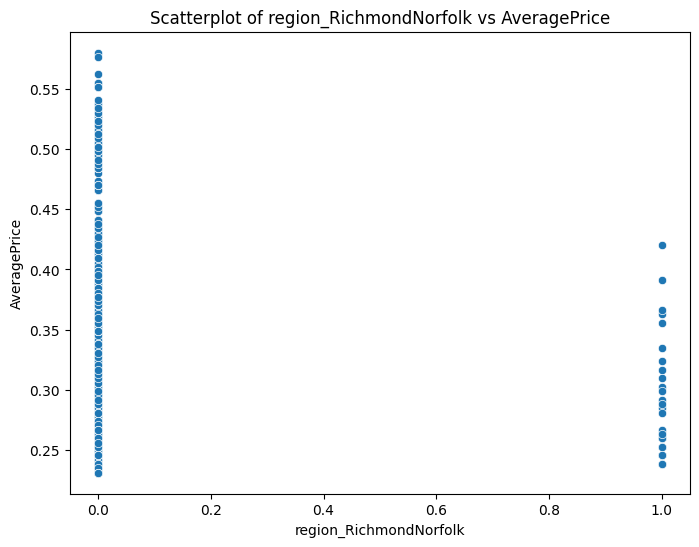

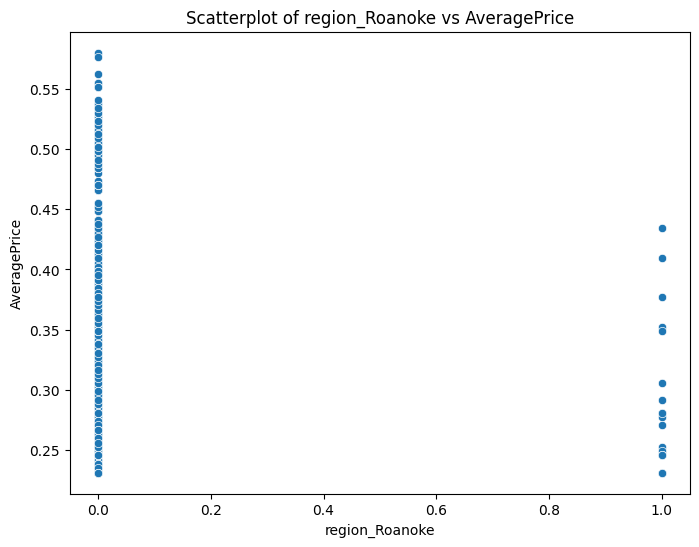

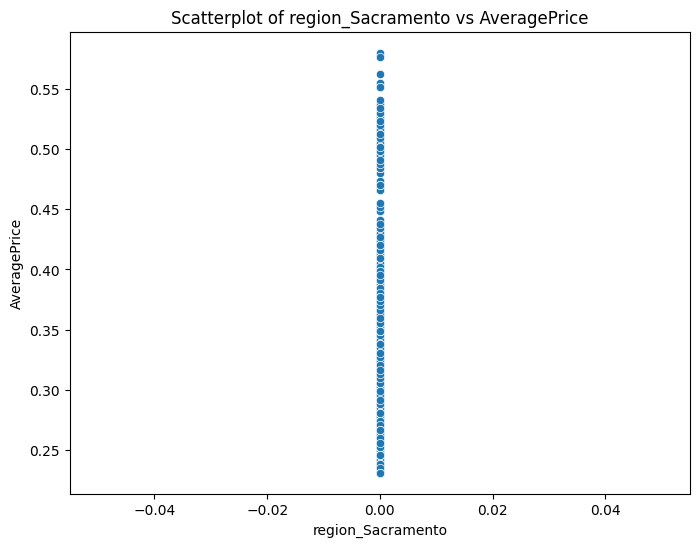

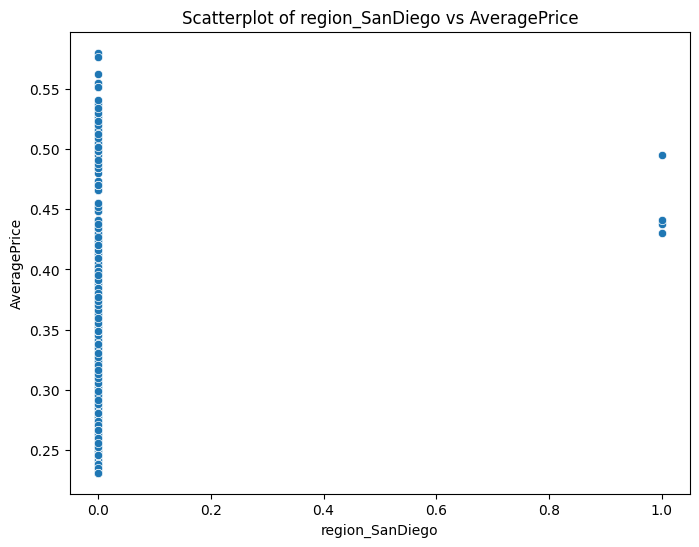

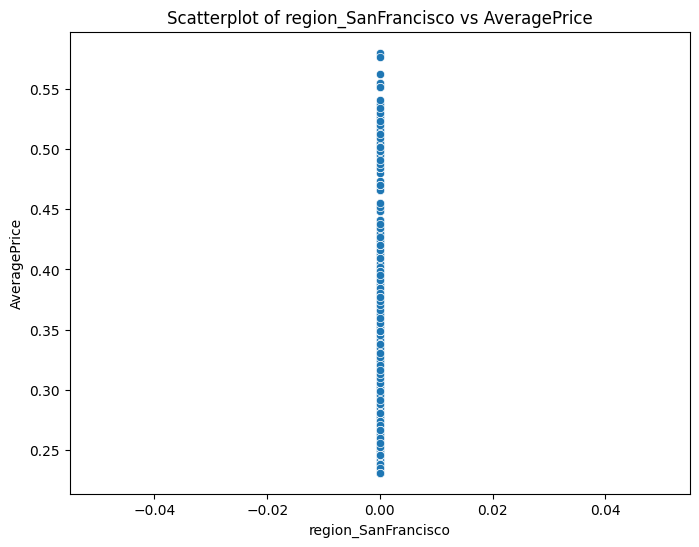

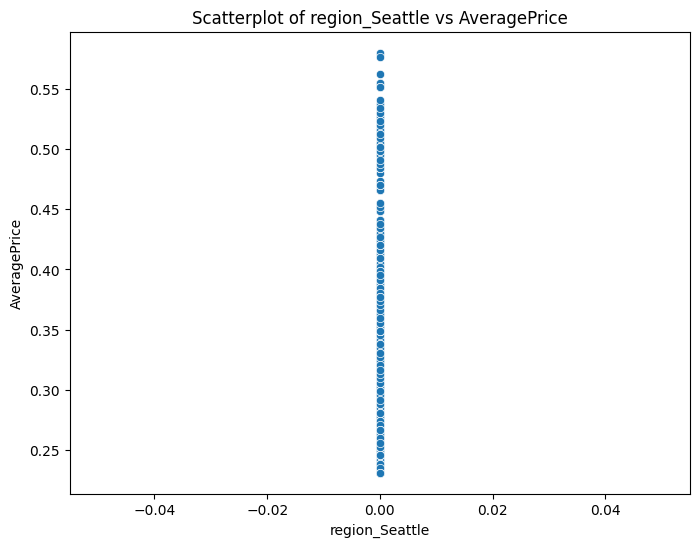

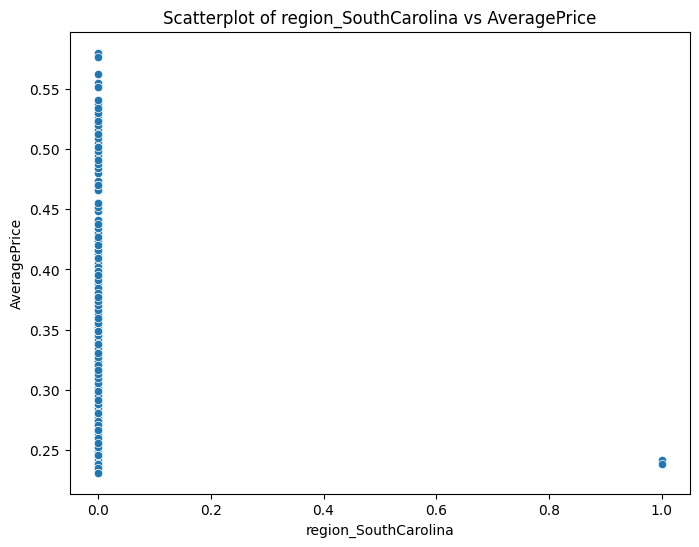

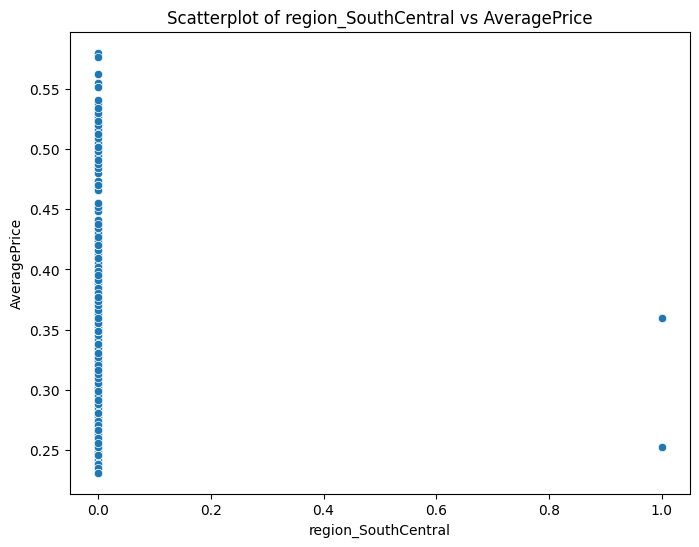

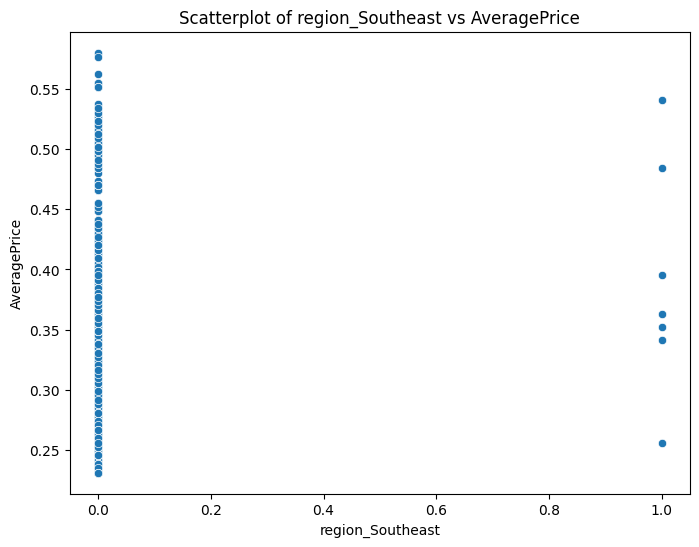

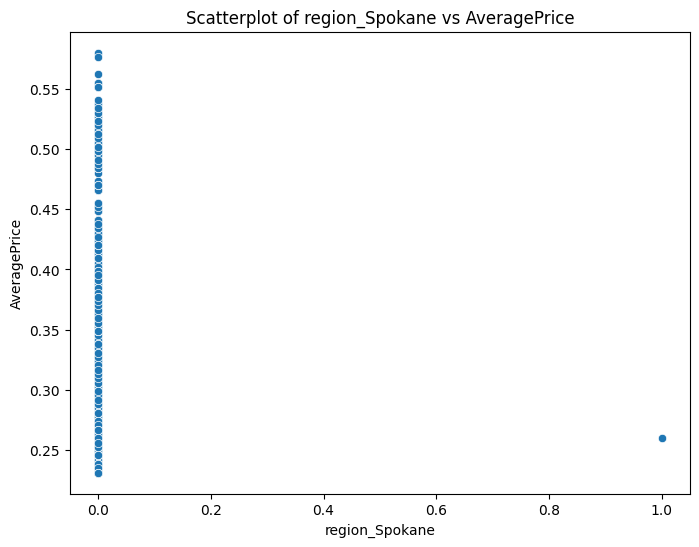

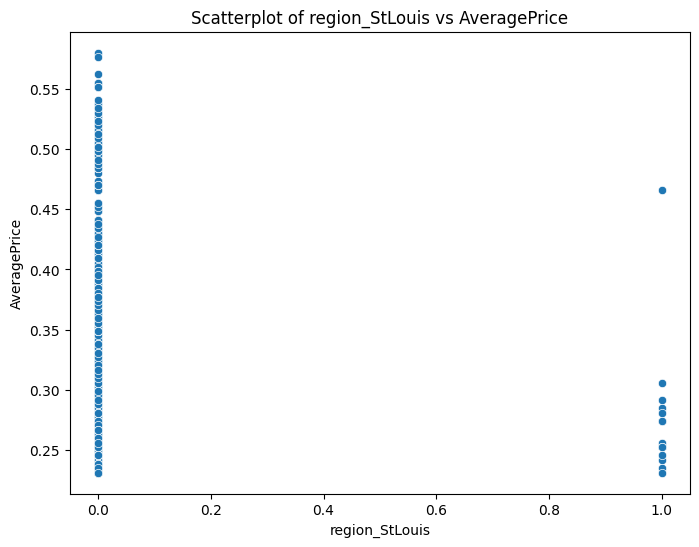

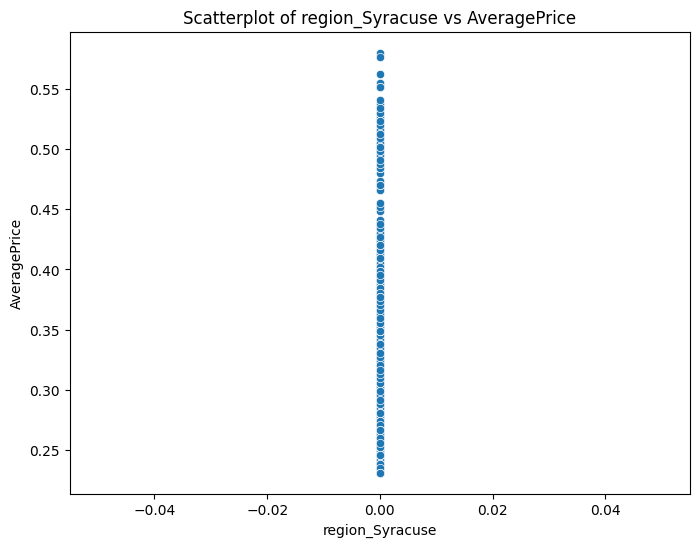

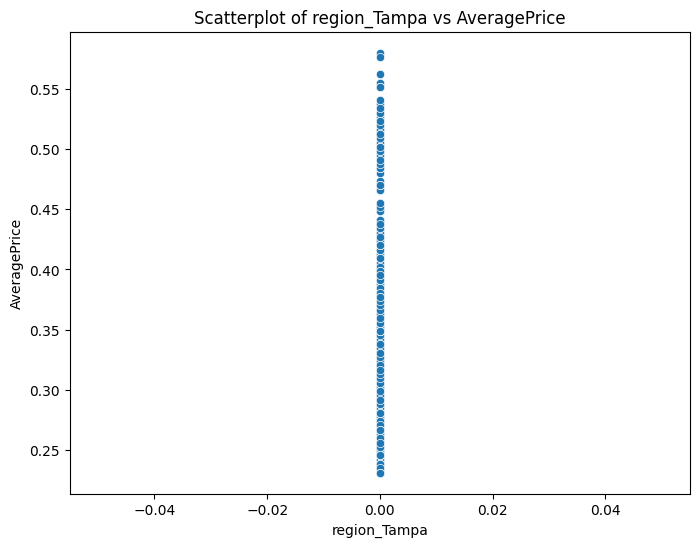

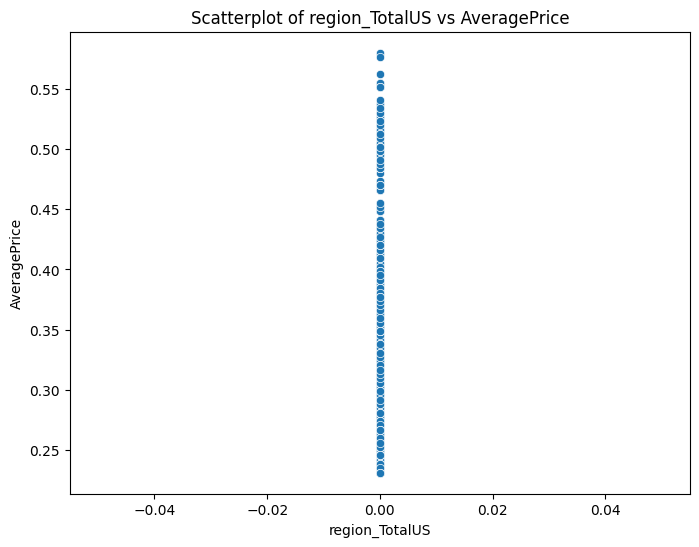

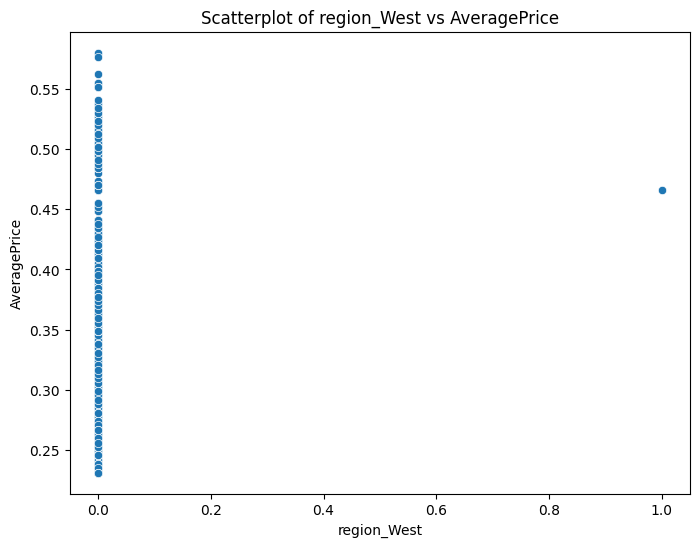

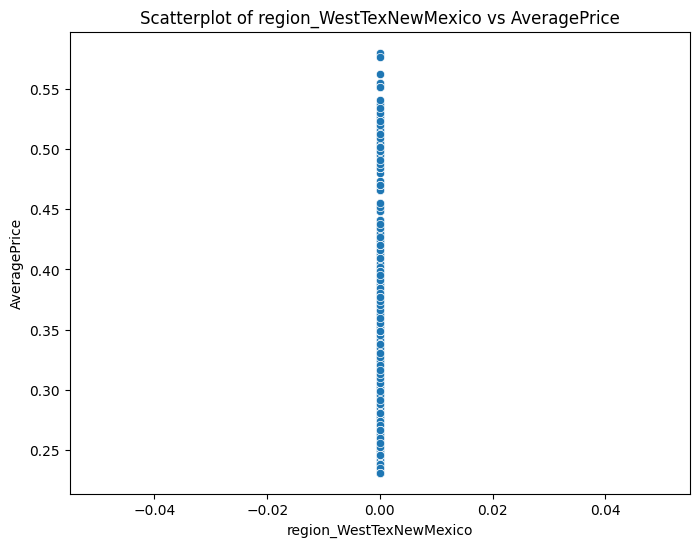

Correlation Matrix:
                             Date  AveragePrice  Total Volume      4046  \
Date                     1.000000      0.368615     -0.069825  0.043093   
AveragePrice             0.368615      1.000000     -0.247282 -0.357665   
Total Volume            -0.069825     -0.247282      1.000000  0.579445   
4046                     0.043093     -0.357665      0.579445  1.000000   
4225                    -0.099314     -0.119816      0.773526  0.053579   
...                           ...           ...           ...       ...   
region_Syracuse               NaN           NaN           NaN       NaN   
region_Tampa                  NaN           NaN           NaN       NaN   
region_TotalUS                NaN           NaN           NaN       NaN   
region_West             -0.013785      0.067191     -0.008591  0.006559   
region_WestTexNewMexico       NaN           NaN           NaN       NaN   

                             4225      4770  Total Bags  Small Bags  \
Date    

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("avocado_cleaned.csv")

# Remove non-numeric columns if present
df_numeric = df.select_dtypes(include=[np.number])

# Split the dataset into independent and dependent variables
X = df_numeric.drop(columns=["AveragePrice"])
y = df_numeric["AveragePrice"]

# Display scatterplot for each independent variable against the dependent variable
for col in X.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[col], y=y)
    plt.title(f"Scatterplot of {col} vs AveragePrice")
    plt.xlabel(col)
    plt.ylabel("AveragePrice")
    plt.show()

# Calculate correlation matrix
correlation_matrix = df_numeric.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Fit a linear model using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Assess relationship strength
y_pred = regr.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Select variables with correlation greater than 0.5 in absolute value
high_correlation_vars = correlation_matrix[abs(correlation_matrix["AveragePrice"]) > 0.5].index.tolist()
print("Variables chosen for prediction:", high_correlation_vars)

# Fit a linear model using the chosen variables
X_chosen = df_numeric[high_correlation_vars]
X_train_chosen, X_test_chosen, y_train_chosen, y_test_chosen = train_test_split(X_chosen, y, test_size=0.2, random_state=42)
regr_chosen = linear_model.LinearRegression()
regr_chosen.fit(X_train_chosen, y_train_chosen)

# Assess relationship strength for chosen variables
y_pred_chosen = regr_chosen.predict(X_test_chosen)
print("Mean squared error (chosen variables): %.2f" % mean_squared_error(y_test_chosen, y_pred_chosen))
print("Coefficient of determination (chosen variables): %.2f" % r2_score(y_test_chosen, y_pred_chosen))